In [ ]:
import pandas as pd
import numpy as np

from datetime import datetime
from dateutil import parser

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

DATA PRE-PROCESSING

In [ ]:
# file paths
bitcoin_price_df_path = 'data/bitcoin_historical_price.csv'
news_df_path = 'data/news_predicted_sentiment.csv'
reddit_posts_df_path = 'data/reddit_predicted_sentiment.csv'


#Historical Bitcoin prices
bitcoin_price_df = pd.read_csv(bitcoin_price_df_path,sep=";")
#news and sentiments
news_df = pd.read_csv(news_df_path)
#Reddit posts and sentiments
reddit_posts_df = pd.read_csv(reddit_posts_df_path)



In [ ]:
#Function to extract date from timestamp format
def parse_date(date_str):
    try:
        # Use dateutil parser to parse the date
        date = parser.parse(date_str, dayfirst=False, yearfirst=True)
        return pd.to_datetime(date.strftime("%Y-%m-%d")).date()
    except ValueError:
        try:
            # Try parsing with day first if the previous attempt failed
            date = parser.parse(date_str, dayfirst=True, yearfirst=False)
            return pd.to_datetime(date.strftime("%Y-%m-%d")).date()
        except ValueError:
            return None

In [ ]:
#Extract date from timestamp in bitcoin_price_df
bitcoin_price_df['date'] = bitcoin_price_df['timeOpen'].apply(parse_date)


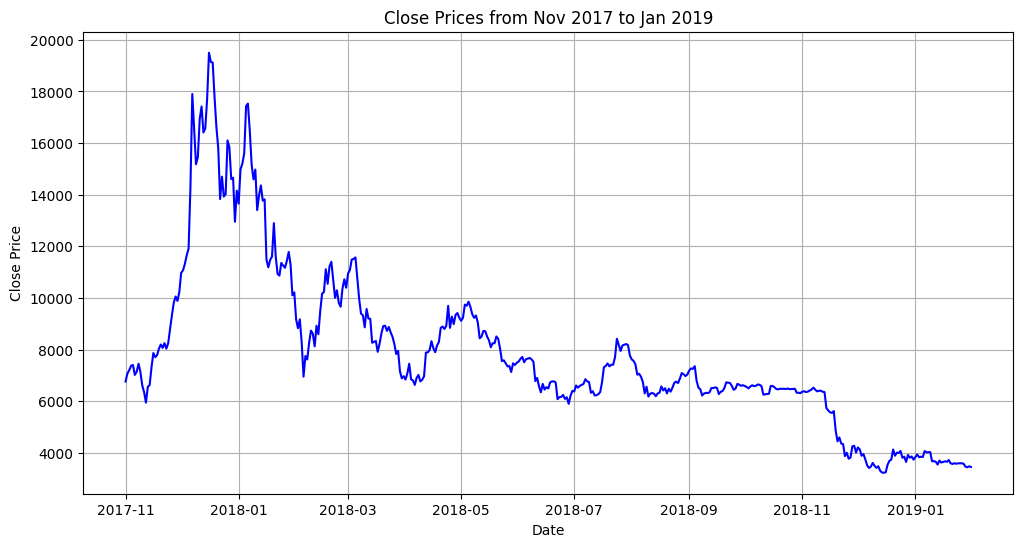

In [ ]:
# Filter the DataFrame for the specified period
bitcoin_2017_2019 = bitcoin_price_df.loc[(bitcoin_price_df['date'] >= pd.to_datetime('2017-11-01').date()) & (bitcoin_price_df['date'] <= pd.to_datetime('2019-01-31').date())]

# Plot the 'close' column over the filtered date range
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_2017_2019['date'], bitcoin_2017_2019['close'], linestyle='-', color='b')
plt.title('Close Prices from Nov 2017 to Jan 2019')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


Formatting news_df

In [ ]:
#Converting sentiments to numerical
news_df['sentiment'] = news_df['sentiment'].astype('int')

In [ ]:
#Extracting date from 'Date' column
news_df['date'] = pd.to_datetime(news_df['date']).dt.date

Formating reddit_posts_df

In [ ]:
#Converting VADER sentiment to numerical values
reddit_posts_df['vader_sentiment'].replace(['Negative','Neutral','Positive'],[0,1,2],inplace=True)

<ipython-input-9-08043f5e8462>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reddit_posts_df['vader_sentiment'].replace(['Negative','Neutral','Positive'],[0,1,2],inplace=True)
<ipython-input-9-08043f5e8462>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  reddit_posts_df['vader_sentiment'].replac

In [ ]:
#Extracting date from 'Created On' column
reddit_posts_df['date'] = pd.to_datetime(reddit_posts_df['Created On']).dt.date


Joining reddit posts sentiment and news sentiment to bitcoin_price_df

In [ ]:
# Calculate mean sentiment for each date in reddit_posts_df
reddit_sentiment_mean = reddit_posts_df.groupby('date')['vader_sentiment'].mean().reset_index()

# Calculate mean sentiment for each date in news_df
news_sentiment_mean = news_df.groupby('date')['sentiment'].mean().reset_index()

# Ensure the date columns are in the same format (date only, without time)
bitcoin_price_df['date'] = pd.to_datetime(bitcoin_price_df['date']).dt.date
reddit_sentiment_mean['date'] = pd.to_datetime(reddit_sentiment_mean['date']).dt.date
news_sentiment_mean['date'] = pd.to_datetime(news_sentiment_mean['date']).dt.date

# Merge the mean sentiment back into bitcoin_price_df based on the date
bitcoin_price_df = pd.merge(bitcoin_price_df, reddit_sentiment_mean, on='date', how='left')
bitcoin_price_df = pd.merge(bitcoin_price_df, news_sentiment_mean, on='date', how='left')

# Rename columns after merging
bitcoin_price_df.rename(columns={
    'vader_sentiment': 'reddit_sentiment',  # Rename VADER sentiment column
    'sentiment': 'news_sentiment'  # Rename news sentiment column
}, inplace=True)

In [ ]:
#Sort based on date
bitcoin_price_df = bitcoin_price_df.sort_values(by='date')
bitcoin_price_df = bitcoin_price_df.reset_index(drop=True)

In [ ]:
#Linear interpolation of news_sentiment to fill missing values
if pd.isnull(bitcoin_price_df.at[0,'news_sentiment']):
    bitcoin_price_df.at[0,'news_sentiment'] = 0
bitcoin_price_df['news_sentiment'] = bitcoin_price_df['news_sentiment'].interpolate(method='linear')


In [ ]:
#Linear interpolation of reddit_sentiment to fill missing values

if pd.isnull(bitcoin_price_df.at[0,'reddit_sentiment']):
    bitcoin_price_df.at[0,'reddit_sentiment'] = 0
bitcoin_price_df['reddit_sentiment'] = bitcoin_price_df['reddit_sentiment'].interpolate(method='linear')


In [ ]:
#Calculating high-low diff and close-open diff
bitcoin_price_df["high_low_diff"]=bitcoin_price_df['high']-bitcoin_price_df['low']


In [ ]:
#Add a new column with price movement 0 = bull and 1 = bear
bitcoin_price_df["close_open_diff"]=bitcoin_price_df['close']-bitcoin_price_df['open']
bitcoin_price_df["price_movement"] = (bitcoin_price_df["close_open_diff"]>=0).astype(int)

In [ ]:
# Calculate Pearson correlation to check influence of each sentiment on Bitcoin price
pearson_corr = bitcoin_price_df[['reddit_sentiment', 'news_sentiment', 'close']].corr(method='pearson')

# Calculate Spearman correlation  to check influence of each sentiment on Bitcoin price
spearman_corr = bitcoin_price_df[['reddit_sentiment', 'news_sentiment', 'close']].corr(method='spearman')

# Display the results
print("Pearson Correlation:\n", pearson_corr)
print("\nSpearman Correlation:\n", spearman_corr)


Pearson Correlation:
                   reddit_sentiment  news_sentiment     close
reddit_sentiment          1.000000       -0.031470  0.176609
news_sentiment           -0.031470        1.000000 -0.104437
close                     0.176609       -0.104437  1.000000

Spearman Correlation:
                   reddit_sentiment  news_sentiment     close
reddit_sentiment          1.000000       -0.000089  0.422589
news_sentiment           -0.000089        1.000000 -0.143663
close                     0.422589       -0.143663  1.000000


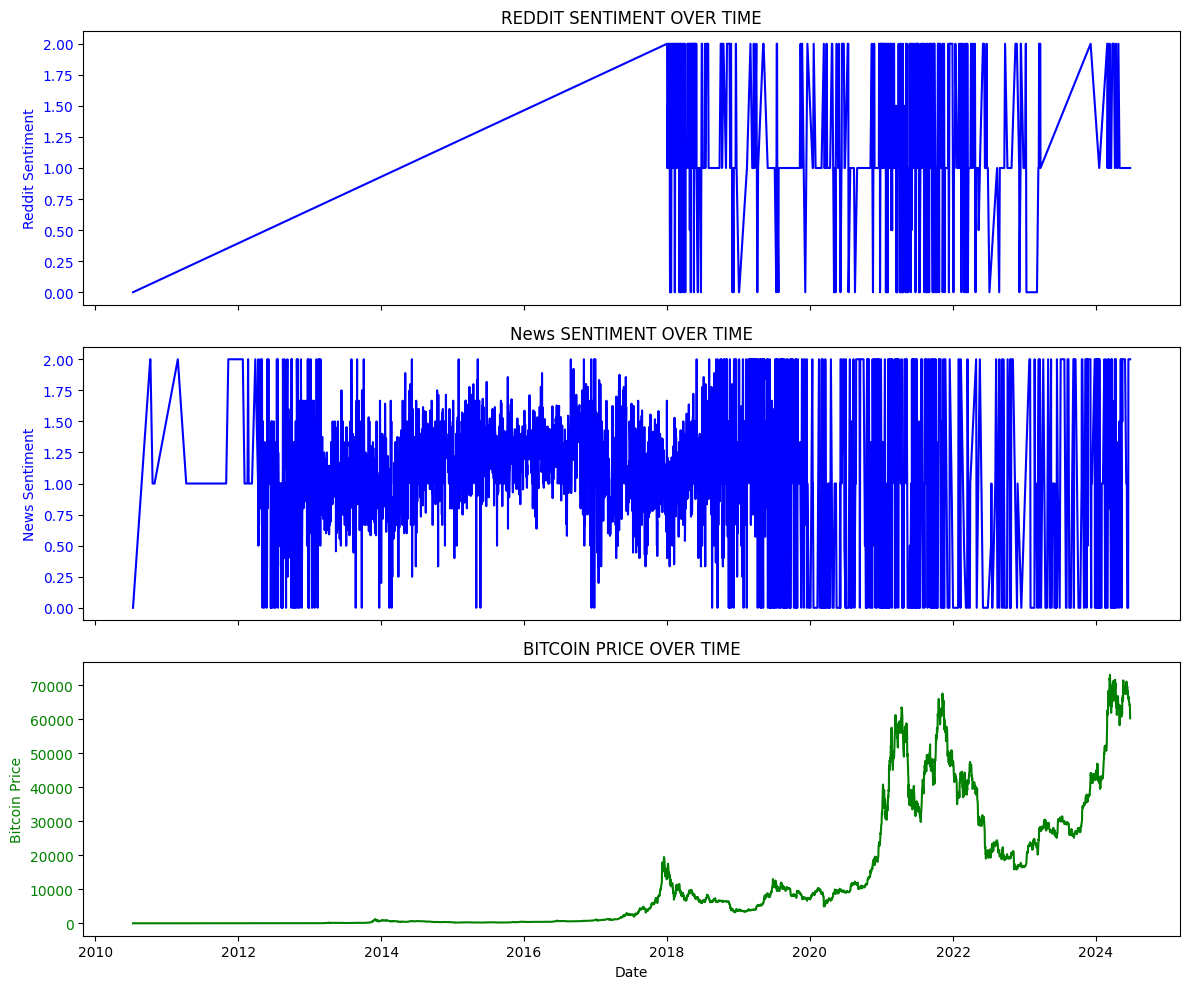

In [ ]:

# Create the figure and two subplots (one for each graph)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plotting Reddit Sentiment on the first subplot
ax1.plot(bitcoin_price_df['date'], bitcoin_price_df['reddit_sentiment'], color='blue', label='Reddit Sentiment')
ax1.set_ylabel('Reddit Sentiment', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('REDDIT SENTIMENT OVER TIME')

# Plotting Reddit Sentiment on the first subplot
ax2.plot(bitcoin_price_df['date'], bitcoin_price_df['news_sentiment'], color='blue', label='Reddit Sentiment')
ax2.set_ylabel('News Sentiment', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_title('News SENTIMENT OVER TIME')

# Plotting Bitcoin Price on the second subplot
ax3.plot(bitcoin_price_df['date'], bitcoin_price_df['close'], color='green', label='Bitcoin Price')
ax3.set_ylabel('Bitcoin Price', color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax3.set_title('BITCOIN PRICE OVER TIME')

# Shared x-axis label
ax3.set_xlabel('Date')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


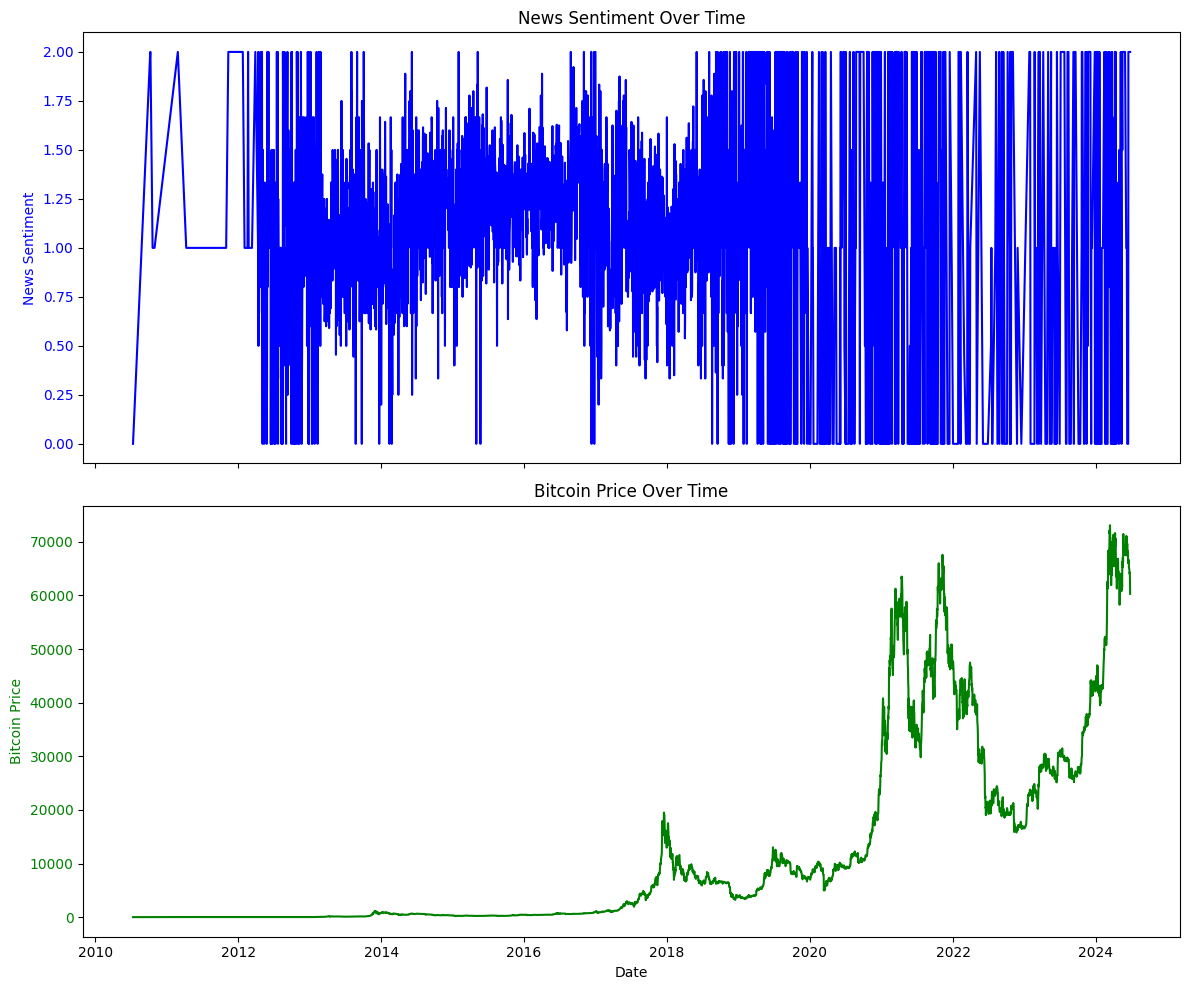

In [ ]:

# Create the figure and two subplots (one for each graph)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plotting Reddit Sentiment on the first subplot
ax1.plot(bitcoin_price_df['date'], bitcoin_price_df['news_sentiment'], color='blue', label='Reddit Sentiment')
ax1.set_ylabel('News Sentiment', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('News Sentiment Over Time')

# Plotting Bitcoin Price on the second subplot
ax2.plot(bitcoin_price_df['date'], bitcoin_price_df['close'], color='green', label='Bitcoin Price')
ax2.set_ylabel('Bitcoin Price', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_title('Bitcoin Price Over Time')

# Shared x-axis label
ax2.set_xlabel('Date')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

#FINDING THE AGGREGATE SENTIMENT

In [ ]:
sentiments = bitcoin_price_df[['reddit_sentiment', 'news_sentiment']]
close = bitcoin_price_df['close']

In [ ]:
from sklearn.model_selection import train_test_split

Sent_train, Sent_test, close_train, close_test = train_test_split(sentiments, close, test_size=0.33, random_state=42)


In [ ]:
#Predicting using linear regression
from sklearn.linear_model import LinearRegression

model_linear = LinearRegression()
model_linear.fit(Sent_train,close_train)

r2_linear = model_linear.score(Sent_test,close_test)
print("R² for Linear Regression:", r2_linear)

R² for Linear Regression: 0.050635146274884746


In [ ]:
#Predicting using Polynomial regression
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
Sent_train_poly = poly.fit_transform(Sent_train)

# Fit the linear regression model on polynomial features
model_poly = LinearRegression()
model_poly.fit(Sent_train_poly, close_train)

Sent_test_poly = poly.fit_transform(Sent_test)
r2_poly = model_poly.score(Sent_test_poly, close_test)
print("R² for Polynomial Regression:", r2_poly)

R² for Polynomial Regression: 0.1796659570712682


In [ ]:
#Predicting using RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor()
model_rf.fit(sentiments, close)

r2_rf = model_rf.score(sentiments, close)
print("R² for Random Forest:", r2_rf)


R² for Random Forest: 0.6369274412858514


In [ ]:
#Coefficients found from RF modeling
model_rf.feature_importances_

array([0.60922073, 0.39077927])

In [ ]:
#Assigning weightages for each sentiment
reddit_weight = model_rf.feature_importances_[0]
news_weight = model_rf.feature_importances_[1]

In [ ]:
#Calculating aggregate sentiment
sentiment_datasets = ['news_sentiment','reddit_sentiment']
# bitcoin_price_df['sentiment'] = bitcoin_price_df[sentiment_datasets].mean(axis=1)
bitcoin_price_df['sentiment'] = (reddit_weight * bitcoin_price_df['reddit_sentiment']) + (news_weight * bitcoin_price_df['news_sentiment'])

In [ ]:
bitcoin_price_df.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp,date,reddit_sentiment,news_sentiment,high_low_diff,close_open_diff,price_movement,sentiment
0,2010-07-13T00:00:00.000Z,2010-07-13T23:59:59.999Z,2010-07-13T02:30:00.000Z,2010-07-13T18:06:00.000Z,2781,0.061833,0.066349,0.052617,0.058163,75.42,194510.84,2010-07-13T23:59:59.999Z,2010-07-13,0.000000,0.000000,0.013732,-0.003670,0,0.000000
1,2010-07-14T00:00:00.000Z,2010-07-14T23:59:59.999Z,2010-07-14T00:34:00.000Z,2010-07-14T19:24:00.000Z,2781,0.058157,0.061588,0.048647,0.056402,261.54,190259.65,2010-07-14T23:59:59.999Z,2010-07-14,0.000733,0.022727,0.012942,-0.001755,0,0.009328
2,2010-07-15T00:00:00.000Z,2010-07-15T23:59:59.999Z,2010-07-15T11:39:00.000Z,2010-07-15T00:41:00.000Z,2781,0.056403,0.067954,0.053969,0.057568,445.80,195982.14,2010-07-15T23:59:59.999Z,2010-07-15,0.001466,0.045455,0.013985,0.001165,1,0.018656
3,2010-07-16T00:00:00.000Z,2010-07-16T23:59:59.999Z,2010-07-16T02:11:00.000Z,2010-07-16T00:24:00.000Z,2781,0.058001,0.072220,0.057484,0.066492,497.25,228047.42,2010-07-16T23:59:59.999Z,2010-07-16,0.002199,0.068182,0.014737,0.008490,1,0.027983
4,2010-07-17T00:00:00.000Z,2010-07-17T23:59:59.999Z,2010-07-17T06:51:00.000Z,2010-07-17T16:21:00.000Z,2781,0.066500,0.077735,0.057418,0.065993,19.99,226904.80,2010-07-17T23:59:59.999Z,2010-07-17,0.002931,0.090909,0.020317,-0.000507,0,0.037311


# PREDICTIVE MODELING

In [ ]:

# Set random seed for reproducibility
tf.random.set_seed(7)

In [ ]:
#Dataframe to store the accuracies for each model
accuracy_comparison = pd.DataFrame()
#File path to save the accuracy dataframe
accuracy_comparison_save_path = 'data/bitcoin_price_prediction_model_comparison.csv'

In [ ]:
def create_dataset(dataset, look_back=1, output_variable=2, features=[1]):
    """
    Function to convert a df column values to a dataset matrix for time-series analysis

    Parameters:
    dataset(pd.DataFrame()): Dataframe which is to be converted to dataset matrix
    look_back(int): Numer of previous time-steps to consider
    output_variable(int): Column index of the output variable
    features(listof int): List of column index/indices of independent variables

    Returns:
    tuple(arrays): Tuple of two arrays
                    dataX: The input feature dataset where each row is a flattened array of independent variables
                    dataY: Target variables
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        # Extract features from the dataset for the current window
        x_values = dataset.iloc[i:(i + look_back), features].values
        # Flatten the features into a single array for each row
        dataX.append(x_values.flatten())
        # Extract the target values for the current window
        dataY.append(dataset.iloc[i + look_back, output_variable])
    return np.array(dataX), np.array(dataY)

In [ ]:

#Filtering the required period of data
start_date = pd.to_datetime('2020-01-01').date()
end_date = pd.to_datetime('2023-03-31').date()
bitcoin_price_df = bitcoin_price_df[(bitcoin_price_df['date']>= start_date) & (bitcoin_price_df['date']<= end_date)]

# start_date = pd.to_datetime('2020-01-01').date()
# end_date = pd.to_datetime('2024-07-31').date()
# bitcoin = bitcoin[(bitcoin['date']>= start_date) & (bitcoin['date']<= end_date)]

In [ ]:
bitcoin_price_df.shape

(1186, 19)

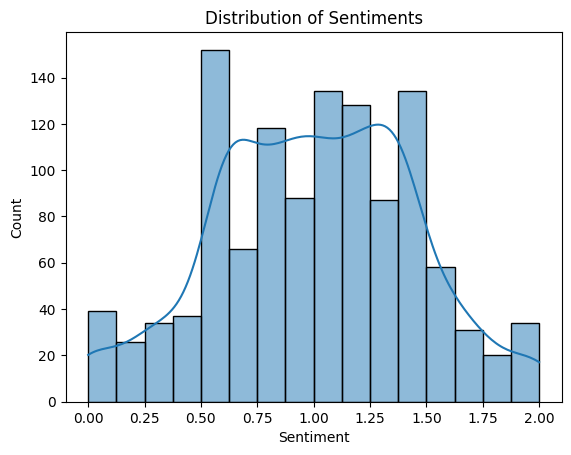

In [ ]:
# Analysing the distribution of the sentiment column
sns.histplot(bitcoin_price_df['sentiment'],kde = True)
plt.xlabel("Sentiment")
plt.title("Distribution of Sentiments")
plt.show()

# CLOSE PRICE PREDICTION

In [ ]:
#Copying required columns to new df
df_close = bitcoin_price_df[['date','sentiment','close']].copy()

In [ ]:
df_close['close'].min()

4970.78790105

In [ ]:
df_close['close'].max()

67566.8300878775

In [ ]:
df_close['close'].mean()

28443.70332074644

In [ ]:
#Analysing correlation of sentiment to close price
correlation = df_close['sentiment'].corr(df_close['close'])
print(f'Correlation between sentiment and close: {correlation}')


Correlation between sentiment and close: 0.13019263947858264


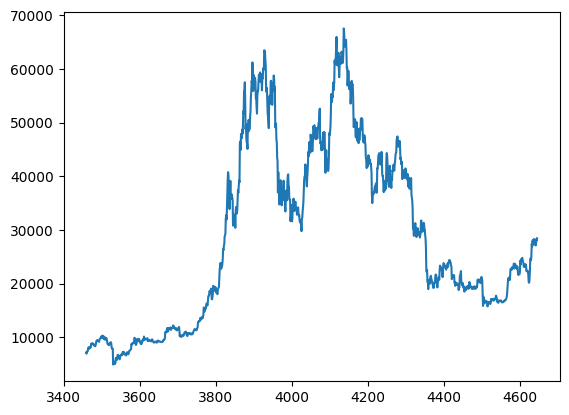

In [ ]:
# Plot for close price
plt.plot(df_close['close'])

In [ ]:
df_close

,date,sentiment,close
3459,2020-01-01,0.925113,7200.174393
3460,2020-01-02,0.902549,6985.470001
3461,2020-01-03,0.879986,7344.884183
3462,2020-01-04,0.857422,7410.656566
3463,2020-01-05,0.921698,7411.317327
...,...,...,...
4640,2023-03-27,0.616360,27139.888531
4641,2023-03-28,0.689791,27268.131483
4642,2023-03-29,0.763221,28348.442343
4643,2023-03-30,0.836652,28033.563150


In [ ]:
#Normalising the values in the range 0,1
scaler_close = MinMaxScaler(feature_range=(0, 1))
scaler_sentiment = MinMaxScaler(feature_range=(0, 1))

In [ ]:
df_close['close'] = scaler_close.fit_transform(df_close['close'].values.reshape(-1,1))
df_close['sentiment'] = scaler_sentiment.fit_transform(df_close['sentiment'].values.reshape(-1,1))

In [ ]:
# split into train and test sets 70%:30%
train_size = int(len(df_close) * 0.70)
test_size = len(df_close) - train_size
train_data, test_data = df_close.iloc[0:train_size,:], df_close.iloc[train_size:len(df_close),:]
print(len(train_data), len(test_data))

#Splitting train set to train and validation set
valid_size = int(len(train_data) * 0.2)  # 20% of the training data for validation
train_data, valid_data = train_data[:-valid_size], train_data[-valid_size:]

print(len(train_data), len(valid_data))


830 356
664 166


In [ ]:
#for each row, features values in the previous 'look_back' number of time steps are considered for prediction
look_back = 10 #Number of previous time steps to consider
predictor = 2 #Column index of outcome. here close price is the outcome
features = [1,2] #Column indices of feature variables. Here sentiment and close-price is considered
#train and validation datasets
X_train, y_train = create_dataset(train_data, look_back,predictor,features)
X_valid, y_valid = create_dataset(valid_data, look_back,predictor,features)

#test datasets
X_test, y_test = create_dataset(test_data, look_back,predictor,features)


In [ ]:
# reshape input(X) to be [samples, time steps, features] to fit the model requirements
X_train_arr = np.reshape(X_train, (X_train.shape[0], look_back, len(features)))
X_valid_arr = np.reshape(X_valid, (X_valid.shape[0], look_back, len(features)))


In [ ]:
X_test_arr = np.reshape(X_test, (X_test.shape[0], look_back, len(features)))


LSTM MODEL

In [ ]:
# create and fit the LSTM network
model = Sequential() #Initialise a sequential model
model.add(LSTM(4, input_shape=(look_back,len(features)))) #Add a LSTM layer
model.add(Dense(1)) #Output layer
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate = 0.0005)) #Initialising loss function and optimizer
final = model.fit(X_train_arr, y_train, epochs=50, batch_size=1, verbose=2,validation_data=(X_valid_arr, y_valid)) #Train the model using train data



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
654/654 - 6s - 9ms/step - loss: 0.0433 - val_loss: 0.0092
Epoch 2/50
654/654 - 4s - 6ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 3/50
654/654 - 2s - 3ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 4/50
654/654 - 2s - 3ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 5/50
654/654 - 2s - 3ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 6/50
654/654 - 2s - 4ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 7/50
654/654 - 2s - 4ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 8/50
654/654 - 2s - 3ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 9/50
654/654 - 3s - 4ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 10/50
654/654 - 2s - 3ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 11/50
654/654 - 3s - 4ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 12/50
654/654 - 4s - 5ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 13/50
654/654 - 4s - 6ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 14/50
654/654 - 2s - 3ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 15/50
654/654 - 3s - 4m

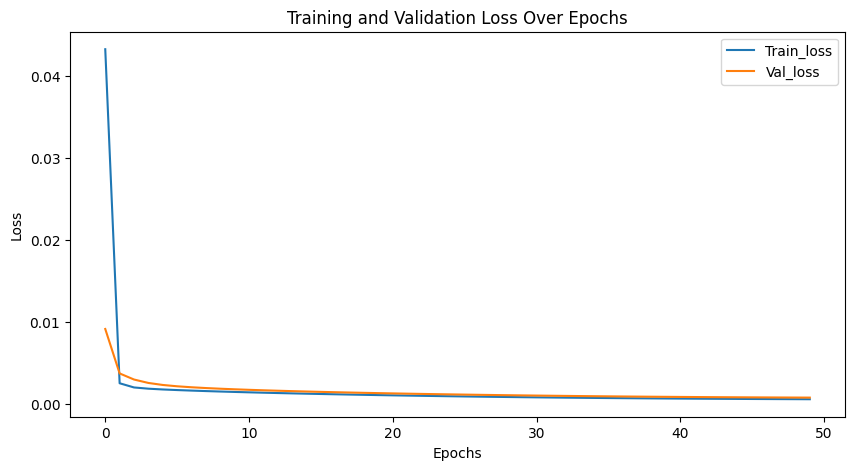

In [ ]:
#Plot validation and train loss
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss Over Epochs')
plt.plot(final.history['loss'], label = 'Train_loss')
plt.plot(final.history['val_loss'],label = 'Val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
final.history['loss'][-1]

0.0006134237628430128

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model("models/lstm_model.h5")

In [ ]:
# Predict for test dataset using the trained model
testPredict = model.predict(X_test_arr)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [ ]:
# invert predictions and actual values back to original scale
testPredict_inv = scaler_close.inverse_transform(testPredict)
y_test_inv = scaler_close.inverse_transform(y_test.reshape(-1,1))

In [ ]:
test_loss = model.evaluate(X_test_arr, y_test, verbose=0)
print('Test Loss: %.2f' % test_loss)
# print('Test Accuracy: %.2f' % test_accuracy)


Test Loss: 0.00


In [ ]:
# calculate root mean squared error
lstm_test_rmse = np.sqrt(mean_squared_error(y_test_inv, testPredict_inv))
print('Test RMSE: %.2f ' % (lstm_test_rmse))

#Mean absolute error
lstm_test_mae = mean_absolute_error(y_test_inv, testPredict_inv)
print('Test MAE: %.2f ' % (lstm_test_mae))

#Mean absolute percentage error
lstm_test_mape = mean_absolute_percentage_error(y_test_inv, testPredict_inv)
print('Test MAPE: %.2f ' % (lstm_test_mape))

#R-2 score
lstm_test_r2 = r2_score(y_test_inv, testPredict_inv)
print('Test R2 score: %.2f ' % (lstm_test_r2))

Test RMSE: 992.16 
Test MAE: 668.80 
Test MAPE: 0.03 
Test R2 score: 0.97 


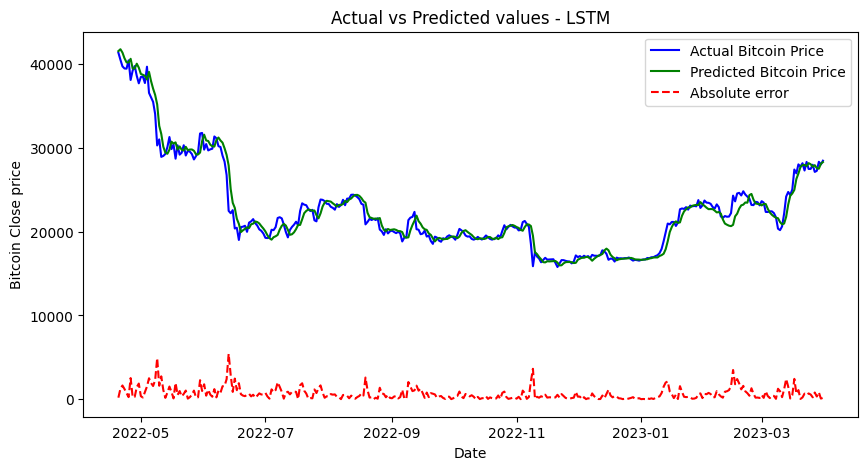

In [ ]:
#calculating the error for each values (actual value-predicted value)
difference = np.abs(y_test_inv - testPredict_inv)
# Plot the actual values, predicted values and the error
plt.figure(figsize=(10, 5))
plt.plot(test_data['date'][-(len(test_data)-look_back):], y_test_inv, color='blue', label='Actual Bitcoin Price')

plt.plot(test_data['date'][-(len(test_data)-look_back):], testPredict_inv, color='green', label='Predicted Bitcoin Price')
plt.plot(test_data['date'][-(len(test_data)-look_back):], difference, color='red', label='Absolute error', linestyle='--')
plt.title('Actual vs Predicted values - LSTM')
plt.xlabel('Date')
plt.ylabel('Bitcoin Close price')
plt.legend()
plt.show()

PRICE MOVEMENT PREDICTION

In [ ]:
test_results = df_close.iloc[train_size + look_back:].copy() #Copying the test dataset to new df with columns ['date', 'sentiment','close']
test_results['predicted_close'] = testPredict  #Adding a new column with predicted values

In [ ]:
#Add a new column with actual and predicted price-movement : 0 for decrease in price movement and 1 for increase in price movement

# Actual price movemnet of the current day is difference between actual close of current day and actua close 4-days back
test_results['actual_price_movement'] = (((test_results['close']- test_results['close'].shift(4)).fillna(0))>=0).astype(int)
# Predicted price movemnet of the current day is difference between predicted close of current day and actual close 4-days back
test_results['predicted_price_movement'] = ((test_results['predicted_close']-test_results['close'].shift(4)).fillna(0)>=0).astype(int)

In [ ]:
#Storing accuracy of price movement prediction by LSTM model
lstm_accuracy = pd.DataFrame({
    'Model': ['Price movement prediction by LSTM'],
    'Accuracy': [accuracy_score(test_results['actual_price_movement'],test_results['predicted_price_movement'])]
})

# Use pd.concat() to add the new row
accuracy_comparison = pd.concat([accuracy_comparison, lstm_accuracy], ignore_index=True)




In [ ]:
#Storing accuracy of price movement prediction by LSTM model (when price is increasing)
lstm_accuracy_price_increase = pd.DataFrame({
    'Model': ['Price movement prediction by LSTM when price is increasing'],
    'Accuracy': [accuracy_score(test_results[test_results['actual_price_movement']==1]['actual_price_movement'],test_results[test_results['actual_price_movement']==1]['predicted_price_movement'])]
})

# Use pd.concat() to add the new row
accuracy_comparison = pd.concat([accuracy_comparison, lstm_accuracy_price_increase], ignore_index=True)



In [ ]:
#Storing accuracy of price movement prediction by LSTM model (when price is decreasing)
lstm_accuracy_price_decrease = pd.DataFrame({
    'Model': ['Price movement prediction by LSTM when price is increasing'],
    'Accuracy': [accuracy_score(test_results[test_results['actual_price_movement']==0]['actual_price_movement'],test_results[test_results['actual_price_movement']==0]['predicted_price_movement'])]
})

# Use pd.concat() to add the new row
accuracy_comparison = pd.concat([accuracy_comparison, lstm_accuracy_price_decrease], ignore_index=True)


LINEAR REGRESSION

In [ ]:
lm = LinearRegression() # Initializing linear model
lm.fit(X_train,y_train) # Training using train data


LinearRegression()

In [ ]:
lm_train_pred = lm.predict(X_train) #Predict using train data
lm_test_pred = lm.predict(X_test) #Predict using test data

PRICE MOVEMENT PREDICTION

In [ ]:

lm_test_results = df_close.iloc[train_size + look_back:].copy() #Copying the test dataset to new df with columns ['date', 'sentiment','close']
lm_test_results['predicted_close'] = lm_test_pred #Adding a new column with predicted values


In [ ]:
#Add a new column with actual and predicted price-movement : 0 for decrease in price movement and 1 for increase in price movement

# Actual price movemnet of the current day is difference between actual close of current day and actua close 4-days back
lm_test_results['actual_price_movement'] = (((lm_test_results['close']-lm_test_results['close'].shift(4)).fillna(0))>=0).astype(int)
# Predicted price movemnet of the current day is difference between predicted close of current day and actual close 4-days back
lm_test_results['predicted_price_movement'] = ((lm_test_results['predicted_close']-lm_test_results['close'].shift(4)).fillna(0)>=0).astype(int)

In [ ]:
#Storing accuracy of price movement prediction by Linear Regressor model
lm_accuracy_price = pd.DataFrame({
    'Model': ['Price movement prediction by Linear Regressor'],
    'Accuracy': [accuracy_score(lm_test_results['actual_price_movement'],lm_test_results['predicted_price_movement'])]
})

# Use pd.concat() to add the new row
accuracy_comparison = pd.concat([accuracy_comparison, lm_accuracy_price], ignore_index=True)


In [ ]:
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, lm_train_pred)))
print('Train MAE:', mean_absolute_error(y_train, lm_train_pred))
print('Train R2-score:', r2_score(y_train, lm_train_pred))

print('Test RMSE:', np.sqrt(mean_squared_error(y_test, lm_test_pred)))
print('Test MAE:', mean_absolute_error(y_test, lm_test_pred))
print('Test R2-score:', r2_score(y_test, lm_test_pred))


Train RMSE: 0.02100261716927668
Train MAE: 0.01283078085665427
Train R2-score: 0.9949959574112223
Test RMSE: 0.012479035206674515
Test MAE: 0.00828037515160611
Test R2-score: 0.9792776298765234


In [ ]:
print('Train RMSE:', np.sqrt(mean_squared_error(scaler_close.inverse_transform(y_train.reshape(-1,1)), scaler_close.inverse_transform(lm_train_pred.reshape(-1,1)))))
print('Train MAE:', mean_absolute_error(scaler_close.inverse_transform(y_train.reshape(-1,1)), scaler_close.inverse_transform(lm_train_pred.reshape(-1,1))))
print('Train MAPE:', mean_absolute_percentage_error(scaler_close.inverse_transform(y_train.reshape(-1,1)),scaler_close.inverse_transform (lm_train_pred.reshape(-1,1))))
print('Train R2-score:', r2_score(scaler_close.inverse_transform(y_train.reshape(-1,1)),scaler_close.inverse_transform (lm_train_pred.reshape(-1,1))))

print('Test RMSE:', np.sqrt(mean_squared_error(scaler_close.inverse_transform(y_test.reshape(-1,1)), scaler_close.inverse_transform(lm_test_pred.reshape(-1,1)))))
print('Test MAE:', mean_absolute_error(scaler_close.inverse_transform(y_test.reshape(-1,1)), scaler_close.inverse_transform(lm_test_pred.reshape(-1,1))))
print('Test MAPE:', mean_absolute_percentage_error(scaler_close.inverse_transform(y_test.reshape(-1,1)), scaler_close.inverse_transform(lm_test_pred.reshape(-1,1))))
print('Test R2-score:', r2_score(scaler_close.inverse_transform(y_test.reshape(-1,1)), scaler_close.inverse_transform(lm_test_pred.reshape(-1,1))))


Train RMSE: 1314.6807103618307
Train MAE: 803.1560997930692
Train MAPE: 0.02893142348473958
Train R2-score: 0.9949959574112223
Test RMSE: 781.1382142479034
Test MAE: 518.3187123126938
Test MAPE: 0.02242549772058437
Test R2-score: 0.9792776298765234


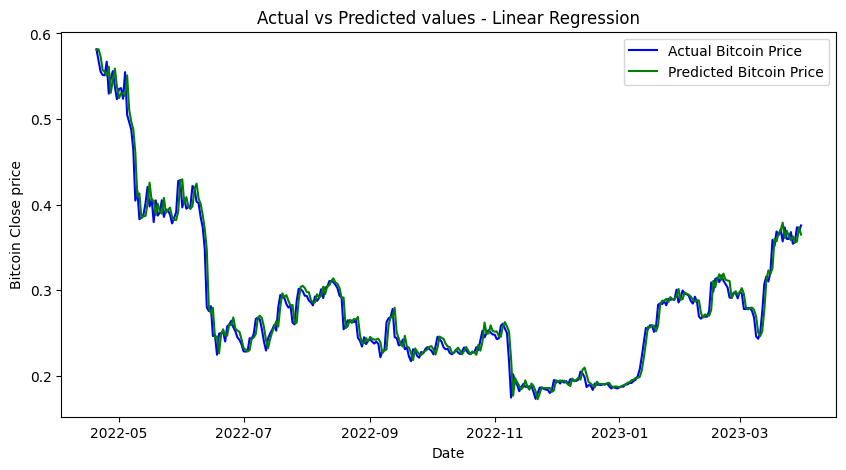

In [ ]:
# Plot the actual and predicted bitcoin price
plt.figure(figsize=(10, 5))
plt.plot(test_data['date'][-(len(test_data)-look_back):], y_test, color='blue', label='Actual Bitcoin Price')

plt.plot(test_data['date'][-(len(test_data)-look_back):], lm_test_pred, color='green', label='Predicted Bitcoin Price')
plt.title('Actual vs Predicted values - Linear Regression')
plt.xlabel('Date')
plt.ylabel('Bitcoin Close price')
plt.legend()
plt.show()

GRADIENT BOOSTING REGRESSOR

In [ ]:
#initialize parameters for GBM
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "absolute_error",
}


In [ ]:
gbm= GradientBoostingRegressor(**params) #Initialise GBM model
gbm.fit(X_train,y_train) #Train using train data

GradientBoostingRegressor(learning_rate=0.01, loss='absolute_error',
                          max_depth=4, min_samples_split=5, n_estimators=500)

In [ ]:
gbm_train_pred = gbm.predict(X_train) #Predict using train data
gbm_test_pred = gbm.predict(X_test) #Predict using test data

PRICE MOVEMENT PREDICTION

In [ ]:
gbm_test_results = df_close.iloc[train_size + look_back:].copy() #Copying the test dataset to new df with columns ['date', 'senti
gbm_test_results['predicted_close'] = gbm_test_pred #Adding a new column with predicted values
gbm_test_results


,date,sentiment,close,predicted_close
4299,2022-04-20,0.839846,0.581564,0.586986
4300,2022-04-21,0.880205,0.568032,0.586986
4301,2022-04-22,0.920563,0.555459,0.561604
4302,2022-04-23,0.960922,0.551408,0.564227
4303,2022-04-24,0.764361,0.551129,0.564921
...,...,...,...,...
4640,2023-03-27,0.308180,0.354161,0.414960
4641,2023-03-28,0.344895,0.356210,0.407773
4642,2023-03-29,0.381611,0.373469,0.413353
4643,2023-03-30,0.418326,0.368438,0.412964


In [ ]:
#Add a new column with actual and predicted price-movement : 0 for decrease in price movement and 1 for increase in price movement

# Actual price movemnet of the current day is difference between actual close of current day and actua close 4-days back
gbm_test_results['actual_price_movement'] = (((gbm_test_results['close']-gbm_test_results['close'].shift(4)).fillna(0))>=0).astype(int)
# Predicted price movemnet of the current day is difference between predicted close of current day and actual close 4-days back
gbm_test_results['predicted_price_movement'] = ((gbm_test_results['predicted_close']-gbm_test_results['close'].shift(4)).fillna(0)>=0).astype(int)


In [ ]:
#Storing accuracy of price movement prediction by GBM model
gbm_accuracy_price = pd.DataFrame({
    'Model': ['Price movement prediction by GBM model'],
    'Accuracy': [accuracy_score(gbm_test_results['actual_price_movement'],gbm_test_results['predicted_price_movement'])]
})

# Use pd.concat() to add the new row
accuracy_comparison = pd.concat([accuracy_comparison, gbm_accuracy_price], ignore_index=True)



In [ ]:
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, gbm_train_pred)))
print('Train MAE:', mean_absolute_error(y_train, gbm_train_pred))
print('Train R2-score:', mean_absolute_percentage_error(y_train, gbm_train_pred))

print('Test RMSE:', np.sqrt(mean_squared_error(y_test, gbm_test_pred)))
print('Test MAE:', mean_absolute_error(y_test, gbm_test_pred))
print('Test R2-score:', mean_absolute_percentage_error(y_test, gbm_test_pred))


Train RMSE: 0.019941448934119303
Train MAE: 0.010923893471093724
Train R2-score: 383752653429.0793
Test RMSE: 0.03397521204044251
Test MAE: 0.027002990363668745
Test R2-score: 0.09970389590735733


In [ ]:
print('Train RMSE:', np.sqrt(mean_squared_error(scaler_close.inverse_transform(y_train.reshape(-1,1)), scaler_close.inverse_transform(gbm_train_pred.reshape(-1,1)))))
print('Train MAE:', mean_absolute_error(scaler_close.inverse_transform(y_train.reshape(-1,1)), scaler_close.inverse_transform(gbm_train_pred.reshape(-1,1))))
print('Train MAPE:', mean_absolute_percentage_error(scaler_close.inverse_transform(y_train.reshape(-1,1)), scaler_close.inverse_transform(gbm_train_pred.reshape(-1,1))))
print('Train R2-score:', r2_score(scaler_close.inverse_transform(y_train.reshape(-1,1)), scaler_close.inverse_transform(gbm_train_pred.reshape(-1,1))))

print('Test RMSE:', np.sqrt(mean_squared_error(scaler_close.inverse_transform(y_test.reshape(-1,1)), scaler_close.inverse_transform(gbm_test_pred.reshape(-1,1)))))
print('Test MAE:', mean_absolute_error(scaler_close.inverse_transform(y_test.reshape(-1,1)), scaler_close.inverse_transform(gbm_test_pred.reshape(-1,1))))
print('Test MAPE:', mean_absolute_percentage_error(scaler_close.inverse_transform(y_test.reshape(-1,1)), scaler_close.inverse_transform(gbm_test_pred.reshape(-1,1))))
print('Test R2-score:', r2_score(scaler_close.inverse_transform(y_test.reshape(-1,1)), scaler_close.inverse_transform(gbm_test_pred.reshape(-1,1))))


Train RMSE: 1248.2557787465985
Train MAE: 683.7924965609923
Train MAPE: 0.027168219713907177
Train R2-score: 0.9954888466949235
Test RMSE: 2126.7138061899486
Test MAE: 1690.2803239747045
Test MAPE: 0.07639190913339847
Test R2-score: 0.8463962713263566


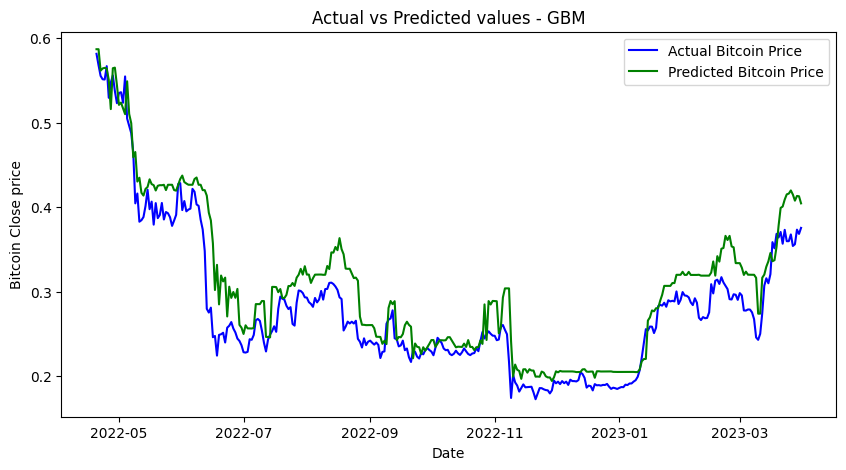

In [ ]:
# Plot the actual and predicted bitcoin price diff
plt.figure(figsize=(10, 5))
plt.plot(test_data['date'][-(len(test_data)-look_back):], y_test, color='blue', label='Actual Bitcoin Price')

plt.plot(test_data['date'][-(len(test_data)-look_back):], gbm_test_pred, color='green', label='Predicted Bitcoin Price')
plt.title('Actual vs Predicted values - GBM')
plt.xlabel('Date')
plt.ylabel('Bitcoin Close price')
plt.legend()
plt.show()

RANDOM FOREST

In [ ]:
rf = RandomForestRegressor() #Initialise RF model
rf.fit(X_train,y_train) #Train using train data

RandomForestRegressor()

In [ ]:
rf_train_pred = rf.predict(X_train) #Predict using train data
rf_test_pred = rf.predict(X_test) #Predict using test data

In [ ]:
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, rf_train_pred)))
print('Train MAE:', mean_absolute_error(y_train, rf_train_pred))
print('Train R2-score:', r2_score(y_train, rf_train_pred))

print('Test RMSE:', np.sqrt(mean_squared_error(y_test, rf_test_pred)))
print('Test MAE:', mean_absolute_error(y_test, rf_test_pred))
print('Test R20score:', r2_score(y_test, rf_test_pred))


Train RMSE: 0.008864230852237144
Train MAE: 0.005293178021882145
Train R2-score: 0.9991086335563156
Test RMSE: 0.0348553814791788
Test MAE: 0.026897903794774455
Test R20score: 0.8383345978139085


In [ ]:
print('Train RMSE:', np.sqrt(mean_squared_error(scaler_close.inverse_transform(y_train.reshape(-1,1)), scaler_close.inverse_transform(rf_train_pred.reshape(-1,1)))))
print('Train MAE:', mean_absolute_error(scaler_close.inverse_transform(y_train.reshape(-1,1)), scaler_close.inverse_transform(rf_train_pred.reshape(-1,1))))
print('Train MAPE:', mean_absolute_percentage_error(scaler_close.inverse_transform(y_train.reshape(-1,1)), scaler_close.inverse_transform(rf_train_pred.reshape(-1,1))))
print('Train MAPE:', r2_score(scaler_close.inverse_transform(y_train.reshape(-1,1)), scaler_close.inverse_transform(rf_train_pred.reshape(-1,1))))

print('Test RMSE:', np.sqrt(mean_squared_error(scaler_close.inverse_transform(y_test.reshape(-1,1)), scaler_close.inverse_transform(rf_test_pred.reshape(-1,1)))))
print('Test MAE:', mean_absolute_error(scaler_close.inverse_transform(y_test.reshape(-1,1)),scaler_close.inverse_transform (rf_test_pred.reshape(-1,1))))
print('Test MAPE:', mean_absolute_percentage_error(scaler_close.inverse_transform(y_test.reshape(-1,1)), scaler_close.inverse_transform(rf_test_pred.reshape(-1,1))))
print('Test R2-score:', r2_score(scaler_close.inverse_transform(y_test.reshape(-1,1)), scaler_close.inverse_transform(rf_test_pred.reshape(-1,1))))


Train RMSE: 554.8657683804142
Train MAE: 331.3319947601229
Train MAPE: 0.011581581465404523
Train MAPE: 0.9991086335563156
Test RMSE: 2181.8089295086415
Test MAE: 1683.7023206749286
Test MAPE: 0.0746912871210475
Test R2-score: 0.8383345978139085


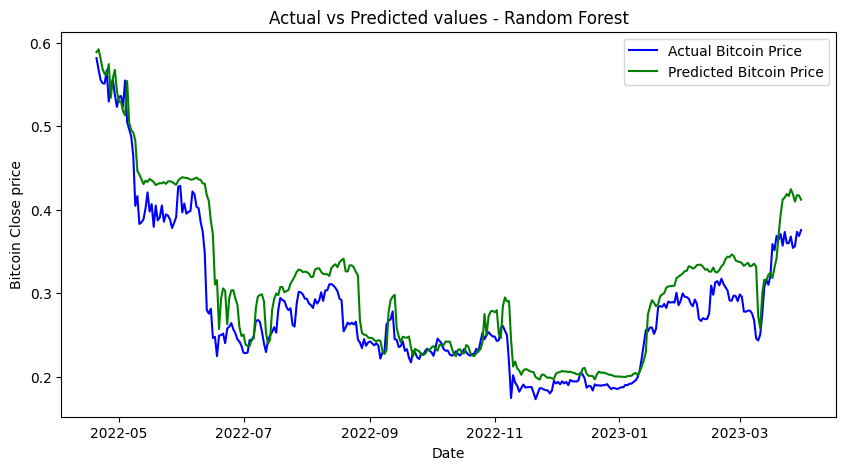

In [ ]:
# Plot the actual and predicted bitcoin price diff
plt.figure(figsize=(10, 5))
plt.plot(test_data['date'][-(len(test_data)-look_back):], y_test, color='blue', label='Actual Bitcoin Price')

plt.plot(test_data['date'][-(len(test_data)-look_back):], rf_test_pred, color='green', label='Predicted Bitcoin Price')
plt.title('Actual vs Predicted values - Random Forest')
plt.xlabel('Date')
plt.ylabel('Bitcoin Close price')
plt.legend()
plt.show()

PRICE MOVEMENT PREDICTION

In [ ]:
rf_test_results = df_close.iloc[train_size + look_back:].copy() #Copying the test dataset to new df with columns ['date', 'sentiment','close']
rf_test_results['predicted_close'] = rf_test_pred #Adding a new column with predicted values


In [ ]:
#Add a new column with actual and predicted price-movement : 0 for decrease in price movement and 1 for increase in price movement

# Actual price movemnet of the current day is difference between actual close of current day and actua close 4-days back
rf_test_results['actual_price_movement'] = (((rf_test_results['close']-rf_test_results['close'].shift(4)).fillna(0))>=0).astype(int)
# Predicted price movemnet of the current day is difference between predicted close of current day and actual close 4-days back
rf_test_results['predicted_price_movement'] = ((rf_test_results['predicted_close']-rf_test_results['close'].shift(4)).fillna(0)>=0).astype(int)

In [ ]:
#Storing accuracy of price movement prediction by Random Forest model
rf_accuracy_price = pd.DataFrame({
    'Model': ['Price movement prediction by Random Forest'],
    'Accuracy': [accuracy_score(rf_test_results['actual_price_movement'],rf_test_results['predicted_price_movement'])]
})

# Use pd.concat() to add the new row
accuracy_comparison = pd.concat([accuracy_comparison, rf_accuracy_price], ignore_index=True)


# FINAL ACCURACY COMPARISONS

In [ ]:
accuracy_comparison

,Model,Accuracy
0,Price movement prediction by LSTM,0.820809
1,Price movement prediction by LSTM when price i...,0.793103
2,Price movement prediction by LSTM when price i...,0.848837
3,Price movement prediction by Linear Regressor,0.832370
4,Price movement prediction by GBM model,0.606936
5,Price movement prediction by Random Forest,0.624277
